In [77]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, \
    precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier
%matplotlib inline 

# Load Data

In [78]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/data_for_model"

In [79]:
# function to load data 
def load_data(filename, root_path=DATAFOLDER):
    csv_path = os.path.join(root_path, filename)
    df = pd.read_csv(csv_path)
    return df 

In [119]:
# load data 
df = load_data(filename="appeals_data_2018-05-13-v6.csv", root_path=DATAFOLDER)
df.set_index('idnAppeal', inplace=True) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
Float64Index: 242262 entries, 4657002.0 to 5021568.0
Data columns (total 60 columns):
idncase                              242262 non-null int64
idnproceeding                        242262 non-null int64
nat_string                           242111 non-null object
ij_code                              242262 non-null object
attorney_flag                        219139 non-null float64
lawyer                               242262 non-null int64
defensive                            236745 non-null float64
affirmative                          236745 non-null float64
oral                                 241822 non-null float64
written                              241822 non-null float64
base_city_code                       242262 non-null object
base_city_state                      242262 non-null object
hearing_loc_city                     242250 non-null object
hearing_loc_code                     242262 non-null object
hearing_loc_state                 

# Data Pipelines

In [120]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'median', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'median': 
        val = col.median() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [121]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [122]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [123]:
# method to subset data for training model 
def get_model_data(df, label, cat_features, num_features, impute_methods): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) # do EDA and limit to smaller list
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [124]:
def evaluate_model(truth, pred): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(truth, (pred>0.5).astype(int))
    recall = recall_score(truth, (pred>0.5).astype(int))
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss, 
               'Precision': precision, 'Recall': recall}
    return metrics

In [125]:
# method to plot ROC 

def plot_roc(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot ROC curve """
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    if model_name is not None: 
        plt.plot(fpr, tpr, label= '{0} (AUC = {1:.3f})'.format(model_name, roc_auc)) 
    else: 
        plt.plot(fpr, tpr, label= 'AUC:{0:.3f}'.format(roc_auc)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('ROC')
    plt.legend(loc="lower right")   

In [126]:
# method to plot precision-recall curve 

def plot_precision_recall(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot precision-recall curve
        Code borrowed from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """    
    precision, recall, _ = precision_recall_curve(truth, pred)
    average_precision = average_precision_score(truth, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b', 
                     label='Avg Precision:{0:.3f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('Precision-Recall curve') 
    plt.legend(loc='lower right')

In [148]:
# method to train a model, output results, and plot AUC 

def train_model(model, X_train, y_train, X_test, y_test, 
                print_metrics=True, print_charts=False, sample_weight=None):
    if sample_weight is not None: 
        model.fit(X_train, y_train.values.ravel(), sample_weight)
    else: 
        model.fit(X_train, y_train.values.ravel())
    truth = y_test.values.ravel()
    pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(truth, pred)
    try: 
        fi, cfi = get_feature_importances(model, X_train)
    except AttributeError: 
        fi, cfi = None, None 
    
    if print_metrics: 
        print(metrics)
    if print_charts: 
        plot_metrics(truth, pred)
    return model, metrics, fi, cfi, truth, pred   

In [128]:
# method to train a model, output results, and plot AUC (WITH FEATURE SELECTION)

# def train_model_with_feature_selection(model, X_train, y_train, X_test, y_test, 
#                                        print_metrics=True, print_charts=False, sample_weight=None,
#                                        feature_selection_threshold="0.25*mean"):
    
#     print("Original Features: {}".format(X_train.shape[1]))
    
#     # perform feature selection 
#     sfm = SelectFromModel(model, threshold=feature_selection_threshold)
#     sfm.fit(X_train, y_train)
#     X_train = sfm.transform(X_train)
#     X_test = sfm.transform(X_test)
#     print("New Features: {}".format(X_train.shape[1]))
    
#     if sample_weight is not None: 
#         model.fit(X_train, y_train.values.ravel(), sample_weight)
#     else: 
#         model.fit(X_train, y_train.values.ravel())
#     truth = y_test.values.ravel()
#     pred = model.predict_proba(X_test)[:,1]
#     metrics = evaluate_model(truth, pred)
# #    fi, cfi = get_feature_importances(model, X_train)
    
#     if print_metrics: 
#         print(metrics)
#     if print_charts: 
#         plot_metrics(truth, pred)
#     return model, metrics, truth, pred  
# #    return model, metrics, fi, cfi, truth, pred   

In [129]:
def plot_metrics(truth, pred): 
    """ Plots ROC and Precision-Recall curves """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_roc(truth, pred)
    plt.subplot(1, 2, 2)
    plot_precision_recall(truth, pred) 

In [130]:
def get_feature_importances(model, X_train):
    
    """ Takes model and train data as inputs, outputs regular and collapsed feature importances """
    
    # get 'regular' feature importances 
    fi = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # get 'collapsed' feature importances (dummy variables of parent feature aggregated as one)
    cfi = pd.DataFrame(fi).reset_index().rename(columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    cfi = cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 
    
    return fi, cfi 

# Test Different Variables 

#### One Variable  

In [92]:
# nationality only 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _  = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                             print_metrics=True, print_charts=False)

Training Data: (193809, 217) | Test Data: (48453, 217)
{'Recall': 0.10477894198824432, 'Log Loss': 0.59012920080914422, 'Precision': 0.55070517125587648, 'ROC AUC': 0.66560755679653072, 'Accuracy': 0.68319815078529711}


In [93]:
# judge only 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)

Training Data: (193809, 421) | Test Data: (48453, 421)
{'Recall': 0.075261947354970604, 'Log Loss': 0.60806823327076809, 'Precision': 0.5038494439692045, 'ROC AUC': 0.62480184407497319, 'Accuracy': 0.67733680061090129}


In [149]:
# appeal year only
CAT_FEATURES = []
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)

Training Data: (193809, 1) | Test Data: (48453, 1)
{'Recall': 0.037311525683618708, 'Log Loss': 0.61843069133212314, 'Precision': 0.51590106007067138, 'ROC AUC': 0.58937951226499929, 'Accuracy': 0.6777082946360391}


#### Two Variables 

In [95]:
# nationality + judge 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

Training Data: (193809, 638) | Test Data: (48453, 638)
{'Recall': 0.34449271658573982, 'Log Loss': 0.85545772178038948, 'Precision': 0.57798263479472611, 'ROC AUC': 0.70079490573583558, 'Accuracy': 0.70699440695106597}
parent_feature
ij_code       0.55163
nat_string    0.44837
Name: importance, dtype: float64


In [96]:
# nationality + judge (grouped) - yields better AUC, will use grouped from here 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

Training Data: (193809, 498) | Test Data: (48453, 498)
{'Recall': 0.34372604140045998, 'Log Loss': 0.84771567539773041, 'Precision': 0.57849462365591398, 'ROC AUC': 0.70077367477865049, 'Accuracy': 0.70709759973582642}
parent_feature
ij_code_grouped    0.57736
nat_grouped        0.42264
Name: importance, dtype: float64


In [97]:
# nationality + appeal year 
CAT_FEATURES = ['nat_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

Training Data: (193809, 130) | Test Data: (48453, 130)
{'Recall': 0.31976744186046513, 'Log Loss': 0.60039912672958251, 'Precision': 0.66194947758233036, 'ROC AUC': 0.73454332752581597, 'Accuracy': 0.72750913256145133}
parent_feature
nat_grouped            0.509312
datAppealFiled_year    0.490688
Name: importance, dtype: float64


In [98]:
# judge + appeal year 
CAT_FEATURES = ['ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

Training Data: (193809, 370) | Test Data: (48453, 370)
{'Recall': 0.28424482494249936, 'Log Loss': 0.6556358376016207, 'Precision': 0.55191663565314475, 'ROC AUC': 0.68113451250407153, 'Accuracy': 0.69423977875466947}
parent_feature
ij_code_grouped        0.613617
datAppealFiled_year    0.386383
Name: importance, dtype: float64


#### Multiple Variables  

Training Data: (193809, 499) | Test Data: (48453, 499)
{'Recall': 0.50415282392026584, 'Log Loss': 1.4084574003629786, 'Precision': 0.61217998448409616, 'ROC AUC': 0.75699422719756049, 'Accuracy': 0.73665201329123065}
parent_feature
ij_code_grouped        0.405473
datAppealFiled_year    0.355548
nat_grouped            0.238979
Name: importance, dtype: float64


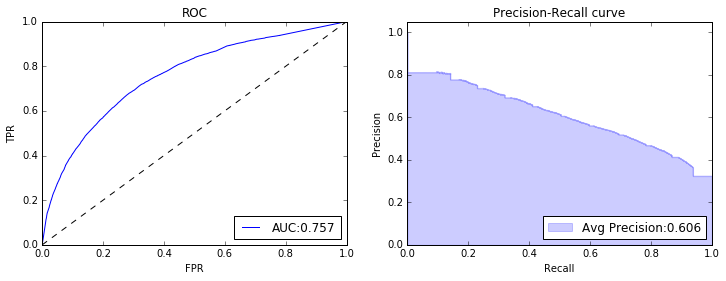

In [99]:
# nationality + judge + appeal year 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

Training Data: (193809, 513) | Test Data: (48453, 513)
{'Recall': 0.52018911321236905, 'Log Loss': 1.4371576421493981, 'Precision': 0.64757814364113575, 'ROC AUC': 0.78064506161352332, 'Accuracy': 0.75355499143499882}
parent_feature
ij_code_grouped        0.395571
datAppealFiled_year    0.275394
nat_grouped            0.224119
strCustody             0.033256
case_type_string       0.025999
lawyer                 0.014999
defensive              0.009245
affirmative            0.009153
oral                   0.006248
written                0.005016
strProbono             0.001000
Name: importance, dtype: float64


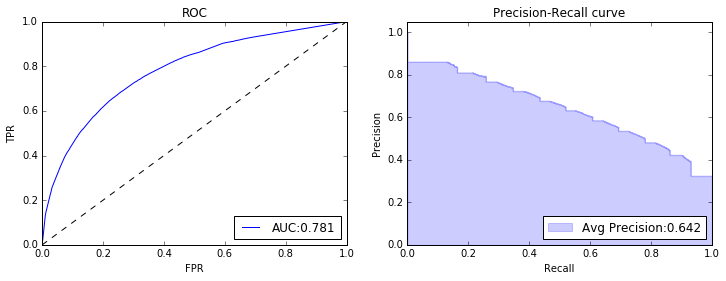

In [101]:
# case type + custody + probono + lawyer + defensive/affirmative + oral/written
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

Training Data: (193809, 516) | Test Data: (48453, 516)
{'Recall': 0.53226424738052647, 'Log Loss': 1.3178032086353859, 'Precision': 0.68579189990121836, 'ROC AUC': 0.80487345500279384, 'Accuracy': 0.77012775266753353}
parent_feature
ij_code_grouped        0.332858
nat_grouped            0.197672
datAppealFiled_year    0.155372
comp_year              0.083038
osc_year               0.075117
input_year             0.069862
strCustody             0.027757
case_type_string       0.019454
lawyer                 0.013191
defensive              0.006858
oral                   0.006651
written                0.005859
affirmative            0.005656
strProbono             0.000655
Name: importance, dtype: float64


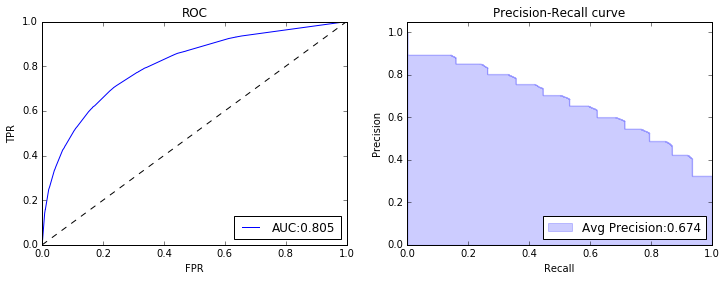

In [131]:
# + comp/osc/input years 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

['original_dec_type_string', 'original_dec_string'] have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.
Training Data: (193809, 538) | Test Data: (48453, 538)
{'Recall': 0.53430871454127271, 'Log Loss': 1.2675741251657078, 'Precision': 0.69064332314807164, 'ROC AUC': 0.80981246224152181, 'Accuracy': 0.77225352403359959}
parent_feature
ij_code_grouped             0.327819
nat_grouped                 0.201126
datAppealFiled_year         0.138695
comp_year                   0.083095
osc_year                    0.074705
input_year                  0.070890
strCustody                  0.029086
original_dec_string         0.028289
lawyer                      0.012638
case_type_string            0.008980
defensive                   0.006933
affirmative                 0.006366
original_dec_type_string    0.005953
oral                        0.002475
written                     0.002289
strProbono                  0.000661
Name: 

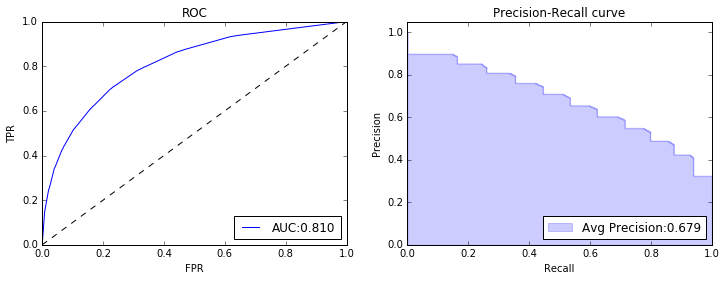

In [133]:
# + original proceeding decisions  
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

['original_dec_type_string', 'original_dec_string'] have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.
Training Data: (193809, 540) | Test Data: (48453, 540)
{'Recall': 0.51450293892154353, 'Log Loss': 1.0918922631370762, 'Precision': 0.71448851033626115, 'ROC AUC': 0.81420947041243275, 'Accuracy': 0.77675272944915696}
parent_feature
ij_code_grouped                      0.278447
nat_grouped                          0.183611
datAppealFiled_year                  0.096703
last_10_appeal_grant_by_judge        0.078728
last_10_appeal_grant_by_judge_nat    0.073434
comp_year                            0.066240
osc_year                             0.064289
input_year                           0.057656
original_dec_string                  0.027049
strCustody                           0.025308
case_type_string                     0.014498
lawyer                               0.012375
affirmative                          0.007320


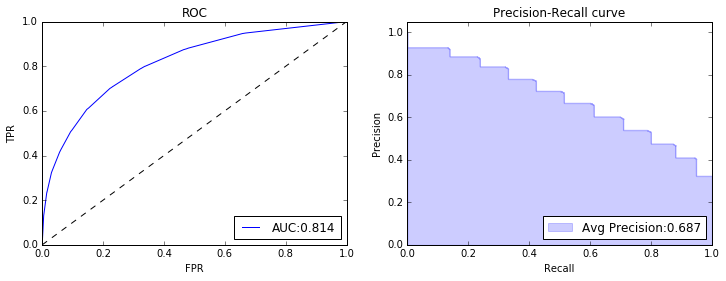

In [141]:
# + last 10 decisions by judge, judge+nationality (improves AUC by 0.0052, keep)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

['original_dec_type_string', 'original_dec_string'] have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.
Training Data: (193809, 542) | Test Data: (48453, 542)
{'Recall': 0.51341681574239717, 'Log Loss': 1.0700053935649403, 'Precision': 0.71298021471031847, 'ROC AUC': 0.81376653810731259, 'Accuracy': 0.77605101851278557}
parent_feature
ij_code_grouped                      0.209613
nat_grouped                          0.172299
datAppealFiled_year                  0.090917
last_10_appeal_grant_by_judge        0.074145
last_10_appeal_grant_by_judge_nat    0.068913
input_year                           0.058855
osc_year                             0.057949
years_since_law_school               0.057873
comp_year                            0.055584
years_since_judge_appointment        0.053576
original_dec_string                  0.028815
strCustody                           0.024533
lawyer                               0.011363


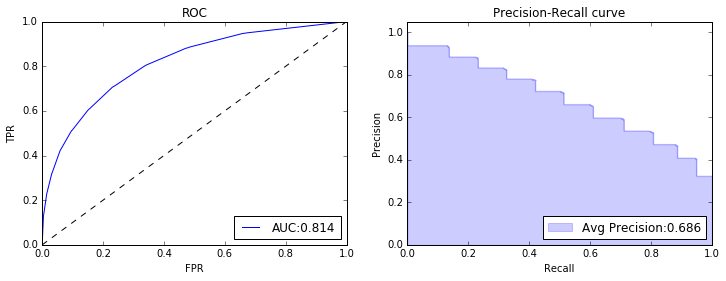

In [142]:
# + judge experience --> AUC slightly worse, exclude 

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat', 
                'years_since_judge_appointment', 'years_since_law_school']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

Training Data: (193809, 540) | Test Data: (48453, 540)
{'Recall': 0.54600051111679015, 'Log Loss': 0.52334972317551931, 'Precision': 0.73349927044888852, 'ROC AUC': 0.83884819295298485, 'Accuracy': 0.78925969496212822}
parent_feature
ij_code_grouped                      0.209613
nat_grouped                          0.172299
datAppealFiled_year                  0.090917
last_10_appeal_grant_by_judge        0.074145
last_10_appeal_grant_by_judge_nat    0.068913
input_year                           0.058855
osc_year                             0.057949
years_since_law_school               0.057873
comp_year                            0.055584
years_since_judge_appointment        0.053576
original_dec_string                  0.028815
strCustody                           0.024533
lawyer                               0.011363
case_type_string                     0.010277
affirmative                          0.007316
original_dec_type_string             0.006484
defensive                     

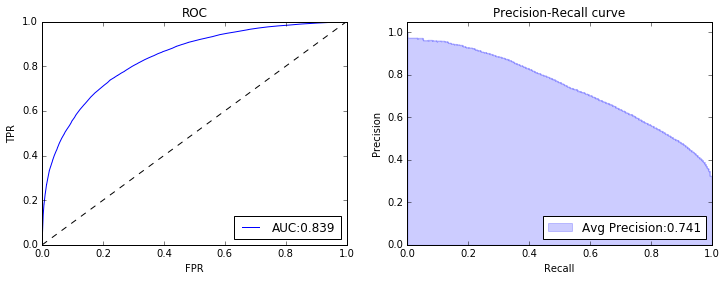

In [143]:
# best with more trees 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_model, rf_metrics, rf_fi, rf_cfi, rf_truth, rf_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)
print(cfi)

# Fit Different Algorithms

#### Logistic Regression

Training Data: (193809, 766) | Test Data: (48453, 766)
{'Recall': 0.37030411449016098, 'Log Loss': 0.53856668461466761, 'Precision': 0.63713312080905793, 'ROC AUC': 0.75130896447443796, 'Accuracy': 0.72845850618124786}


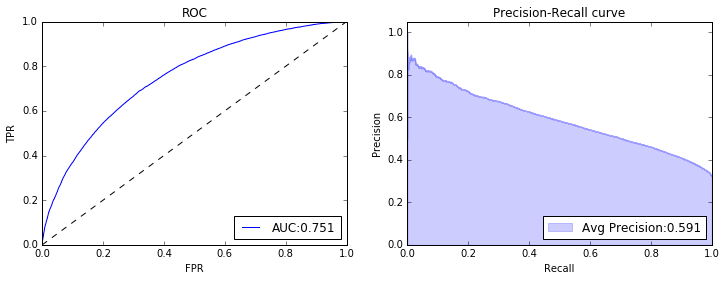

In [150]:
# for lr we dummify "numerical variables" so we don't assume any linear or monotonic relationship 
# between the numerical variable and log odds 

from sklearn.linear_model import LogisticRegression

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string', 
                'datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (LogisticRegression(penalty='l2', C=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
lr_model, lr_metrics, lr_fi, lr_cfi, lr_truth, lr_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)

#### Gradient Boosting

Training Data: (193809, 540) | Test Data: (48453, 540)
{'Recall': 0.30820342448249427, 'Log Loss': 0.53573322268287338, 'Precision': 0.68757126567844928, 'ROC AUC': 0.75862188100000982, 'Accuracy': 0.7312859884836852}


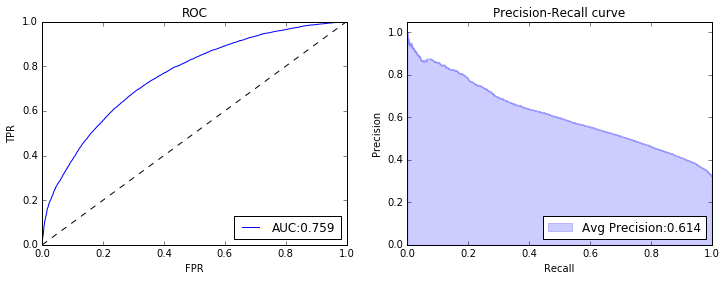

In [145]:
from sklearn.ensemble import GradientBoostingClassifier

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=100, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
gb_model, gb_metrics, gb_fi, gb_cfi, gb_truth, gb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)

#### XGBoost 

Training Data: (193809, 540) | Test Data: (48453, 540)
{'Recall': 0.29536161512905701, 'Log Loss': 0.53777530465368162, 'Precision': 0.68897168405365128, 'ROC AUC': 0.75623572203520839, 'Accuracy': 0.72930468701628381}


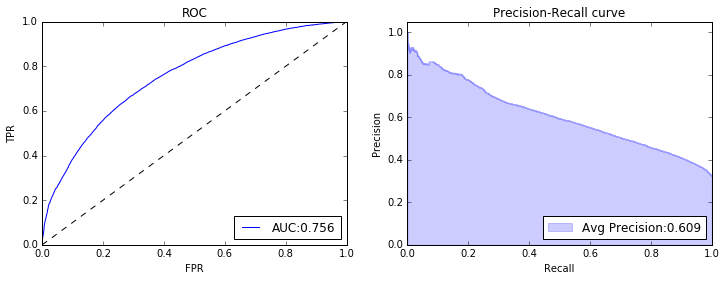

In [151]:
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, seed=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
xgb_model, xgb_metrics, xgb_fi, xgb_cfi, xgb_truth, xgb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                           print_metrics=True, print_charts=True)

#### Algorithm Comparison (out-of-the-box)

In [152]:
algo_comparison = {'Random Forest': rf_metrics, 
                   'Logistic Regression': lr_metrics, 
                   'Gradient Boosting': gb_metrics, 
                   'XGBoost': xgb_metrics}

pd.DataFrame.from_dict(algo_comparison, orient='index').sort_values(by='ROC AUC', ascending=False)

,Recall,Log Loss,Precision,ROC AUC,Accuracy
Random Forest,0.546001,0.523350,0.733499,0.838848,0.789260
Gradient Boosting,0.308203,0.535733,0.687571,0.758622,0.731286
XGBoost,0.295362,0.537775,0.688972,0.756236,0.729305
Logistic Regression,0.370304,0.538567,0.637133,0.751309,0.728459


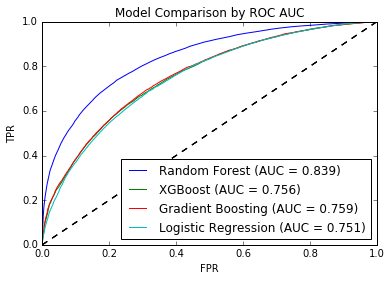

In [153]:
# plot all ROC in a single chart 
plot_roc(rf_truth, rf_pred, 'Random Forest')
plot_roc(xgb_truth, xgb_pred, 'XGBoost')
plot_roc(gb_truth, gb_pred, 'Gradient Boosting')
plot_roc(lr_truth, lr_pred, 'Logistic Regression')
plt.title('Model Comparison by ROC AUC'); 

Since Random Forest outperforms other algorithms significantly in accuracy and ROC AUC out-of-the-box, we will move forward with Random Forest and tune it to get our best model.  

# Tune Random Forest 

In [165]:
from sklearn.model_selection import GridSearchCV

# define search scope 
max_features = ['sqrt', 'log2']
max_depth = list(np.arange(10, 120, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# construct param grid 
param_grid = {'max_features': max_features, 'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# run randomized search cv 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
X_train, _, y_train, _ = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                        num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_clf = RandomForestClassifier(n_estimators=20, random_state=44)
rf_gridsearch = GridSearchCV(rf_clf, param_grid, scoring=['roc_auc', 'accuracy', 'neg_log_loss'], refit='roc_auc')
rf_gridsearch.fit(X_train, y_train)

Training Data: (197824, 656) | Test Data: (49456, 656)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['roc_auc', 'accuracy', 'neg_log_loss'], verbose=0)

In [168]:
def evaluate_search_cv(cv_object): 
    """ Print results for randomized search cv """
    rename_cols = {'param_max_depth': 'max_depth', 
                   'param_max_features': 'max_features', 
                   'param_min_samples_leaf': 'min_samples_leaf', 
                   'param_min_samples_split': 'min_samples_split', 
                   'mean_test_roc_auc': 'roc_auc', 
                   'mean_test_accuracy': 'accuracy', 
                   'mean_train_neg_log_loss': 'neg_log_loss'}
    results = pd.DataFrame(cv_object.cv_results_)
    results.rename(columns=rename_cols, inplace=True)
    results = results[['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 
                       'roc_auc', 'accuracy', 'neg_log_loss']]
    return results.sort_values(by='roc_auc', ascending=False)

In [169]:
evaluate_search_cv(rf_gridsearch)

,max_depth,max_features,min_samples_leaf,min_samples_split,roc_auc,accuracy,neg_log_loss
164,100,sqrt,1,10,0.811757,0.772808,-0.316458
254,None,sqrt,1,10,0.811488,0.773986,-0.297860
200,120,sqrt,1,10,0.811389,0.773582,-0.306301
182,110,sqrt,1,10,0.811372,0.773106,-0.309974
218,130,sqrt,1,10,0.811127,0.773582,-0.303103
146,90,sqrt,1,10,0.811055,0.772495,-0.325095
128,80,sqrt,1,10,0.810963,0.771944,-0.338146
127,80,sqrt,1,5,0.810818,0.773010,-0.295395
163,100,sqrt,1,5,0.810774,0.772849,-0.270914
145,90,sqrt,1,5,0.810604,0.772950,-0.282071


In [178]:
print rf_gridsearch.best_params_

{'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 100, 'min_samples_leaf': 1}


Training Data: (193809, 540) | Test Data: (48453, 540)
{'Recall': 0.51539739330437007, 'Log Loss': 0.45815532437476819, 'Precision': 0.75251865671641793, 'ROC AUC': 0.83734387153383882, 'Accuracy': 0.78870245392442162}


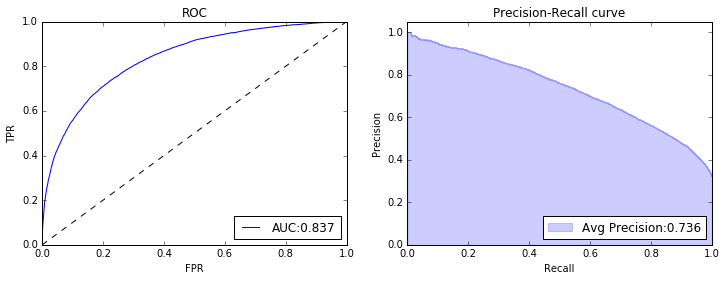

In [173]:
# retrain with best params on 100 trees (NEED TO RETRAIN)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_best_model, rf_best_metrics, rf_best_fi, rf_best_cfi, rf_best_truth, rf_best_pred = train_model(
    MODEL, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=True)

In [155]:
algo_comparison_tuned = {'Random Forest (Tuned)': rf_best_metrics,
                         'Random Forest': rf_metrics} 

pd.DataFrame.from_dict(algo_comparison_tuned, orient='index').sort_values(by='ROC AUC', ascending=False)

,Recall,Log Loss,Precision,ROC AUC,Accuracy
Random Forest,0.546001,0.523350,0.733499,0.838848,0.789260
Random Forest (Tuned),0.515397,0.458155,0.752519,0.837344,0.788702


In [158]:
# check feature importances 
rf_best_fi.head(20)

datAppealFiled_year                          0.094496
last_10_appeal_grant_by_judge_nat            0.058293
comp_year                                    0.057040
input_year                                   0.051077
osc_year                                     0.049844
last_10_appeal_grant_by_judge                0.046614
nat_grouped:::EL SALVADOR                    0.028048
nat_grouped:::HAITI                          0.022009
nat_grouped:::GUATEMALA                      0.012363
lawyer                                       0.011149
strCustody:::N                               0.009348
original_dec_string:::VOLUNTARY DEPARTURE    0.009070
nat_grouped:::CHINA                          0.009044
strCustody:::D                               0.009014
case_type_string:::DEPORTATION               0.008552
nat_grouped:::NICARAGUA                      0.008050
original_dec_string:::RELIEF GRANTED         0.007918
original_dec_string:::REMOVE                 0.007038
affirmative                 

In [159]:
# check collapsed feature importances 
rf_best_cfi

parent_feature
ij_code_grouped                      0.315647
nat_grouped                          0.219132
datAppealFiled_year                  0.094496
last_10_appeal_grant_by_judge_nat    0.058293
comp_year                            0.057040
input_year                           0.051077
osc_year                             0.049844
last_10_appeal_grant_by_judge        0.046614
original_dec_string                  0.031201
strCustody                           0.024284
case_type_string                     0.016245
lawyer                               0.011149
affirmative                          0.006824
original_dec_type_string             0.006247
defensive                            0.005976
oral                                 0.002739
written                              0.002425
strProbono                           0.000769
Name: importance, dtype: float64

# Probability Calibration

Probability calibration can sometimes be an issue for random forest. But it appears that our classifier is already well-calibrated, so we deem it unnecessary to proceed with calibration methods like Platt Scaling. 

In [160]:
from sklearn.calibration import calibration_curve 
y_pred_outofbox = rf_model.predict_proba(X_test)[:,1]
y_pred_best = rf_best_model.predict_proba(X_test)[:,1]
calibration_outofbox = calibration_curve(y_test, y_pred_outofbox, n_bins=10)
calibration_best = calibration_curve(y_test, y_pred_best, n_bins=10)

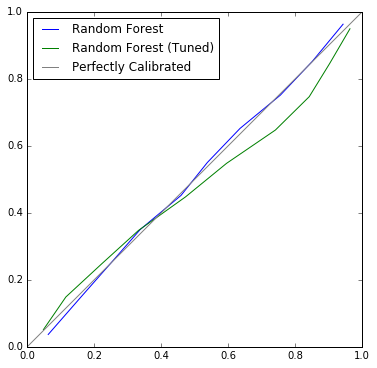

In [161]:
plt.figure(figsize=(6, 6))
plt.plot(calibration_outofbox[0], calibration_outofbox[1], label='Random Forest')
plt.plot(calibration_best[0], calibration_best[1], label='Random Forest (Tuned)')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Perfectly Calibrated', color='grey')
plt.legend(loc='best');

# Partial Dependence Plots (To Fix)

In [174]:
from pdpbox import pdp

def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=1000, plot_samples=200): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # if feature is categorical, generate list of dummy variable names, else use feature name 
    if feature_is_cat: 
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

In [177]:
# pdp_plot(rf_best_model, X_train, 'datAppealFiled_year', feature_is_cat=False) 

In [178]:
# pdp_plot(rf_model, X_train, 'strCustody', feature_is_cat=True)

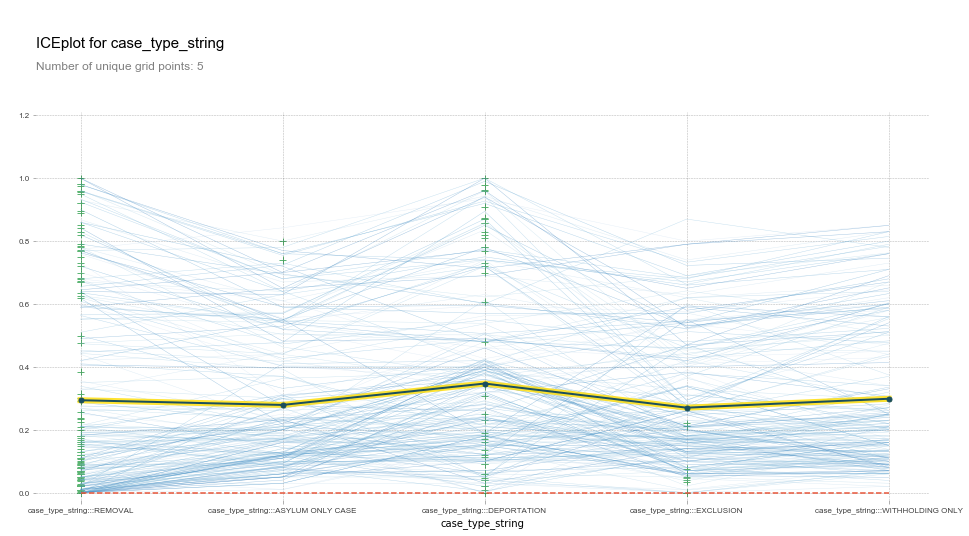

In [53]:
pdp_plot(rf_model, X_train, 'case_type_string', feature_is_cat=True)

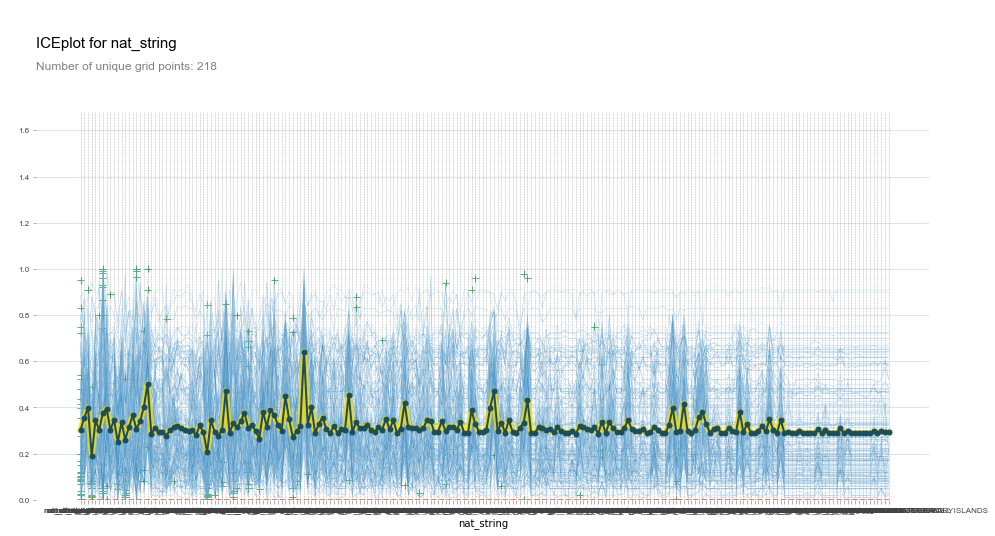

In [50]:
pdp_plot(rf_model, X_train, 'nat_string_grouped', feature_is_cat=True)

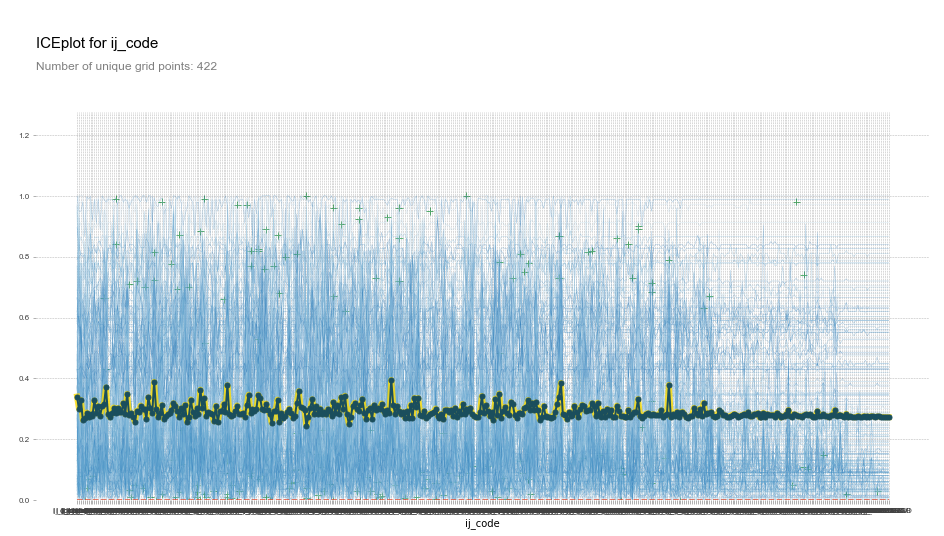

In [52]:
pdp_plot(rf_model, X_train, 'ij_code_grouped', feature_is_cat=True)

# Sequential Models

Thus far we aggregated data across time as a single population from which we drew train and test samples from. This might not be the most realistic way to build a model that is used to predict future appeal outcomes (i.e. we do not have the luxury of using data from future appeals to inform the outcome of a current appeal). To more realistically assess the power of our predictive models, we will build a sequence of models: one model to predict each year's of appeals (by datAppealFiled_year) between 1991 and 2013 using data in preceeding years. In other words, we will only use data from 2000 and earlier to predict 2001's appeals, data from 2001 and earlier to predict 2002's appeals etc. 

In [165]:
def get_model_data_by_year(df, label, cat_features, num_features, impute_methods, predict_year): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # add 'datAppealFiled_year' if not in num_features 
    if 'datAppealFiled_year' not in num_features: 
        num_features_ = num_features + ['datAppealFiled_year'] 
    else: 
        num_features_ = num_features 
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) 
    data = df[cat_features + num_features_ + [label]].copy() 
    
    # train test split 
    train_data = data[data['datAppealFiled_year'] < predict_year]
    test_data = data[data['datAppealFiled_year'] == predict_year]
    x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
    x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [166]:
def fit_sequential_models(df, label, cat_features, num_features, impute_methods, 
                          start_year, end_year, weight_decay=None, print_charts=False, print_metrics=True): 
    """ Trains a sequence of models using data from preceeding years to test on current year """
    
    # initialize empty dictionary to collect all results 
    sequential_results = {}
    
    # loop through each year to train model on data from preceeding years then test on current year 
    for year in np.arange(start_year, end_year+1, 1): 
        print("Training model to predict {} appeals...".format(year)) 
        result = {} # initialize empty dictionary to collect result for each year 
        X_train, X_test, y_train, y_test = get_model_data_by_year(
            df, label='granted', cat_features = cat_features, num_features = num_features, 
            impute_methods = impute_methods, predict_year=year) 
        
        # weight samples 
        if weight_decay is not None:
            print(weight_decay)
            sample_weight = X_train['datAppealFiled_year'].apply(lambda x: weight_decay ** (year-x-1))
        else: 
            sample_weight = None 
        
        # datAppealFiled_year is included in X_train by default; remove if not in num_features
        if 'datAppealFiled_year' not in num_features: 
            X_train = X_train[[c for c in X_train.columns if c != 'datAppealFiled_year']]
            X_test = X_test[[c for c in X_train.columns if c != 'datAppealFiled_year']]
        else: 
            pass 
        
        # save results to dictionary 
        result['model'], result['metrics'], result['fi'], result['cfi'], result['truth'], result['pred'] = train_model(
            MODEL, X_train, y_train, X_test, y_test, 
            print_charts=print_charts, print_metrics=print_metrics, sample_weight=sample_weight) 
        sequential_results[year] = result 
        
    # summarize model performance metrics 
    metric_summary = pd.DataFrame.from_dict(sequential_results, orient='index')['metrics'].apply(pd.Series)
    print(metric_summary)
    print("Average model performance metrics:")
    print(metric_summary.mean()) 
    plot_sequential_performance(metric_summary)
    
    # average feature importances 
    average_cfi = pd.DataFrame.from_dict(sequential_results, orient='index')['cfi']\
                              .apply(pd.Series).mean().sort_values(ascending=False)
    print("Average feature importances:")
    print(average_cfi)     
    
    return metric_summary, average_cfi, sequential_results 

In [167]:
def plot_sequential_performance(sequential_metrics):
    """ Plots AUC and Accuracy by test year """
    plt.figure(figsize=(10, 4))
    plt.plot(sequential_metrics['ROC AUC'])
    plt.plot(sequential_metrics['Accuracy'])
    plt.ticklabel_format(useOffset=False)
    plt.title('Accuracy and AUC of Sequential Models')
    plt.xlabel('Test Year')
    plt.legend(loc='best') 

It appears that building the model in a sequential way degraded the performance considerably. Perhaps even more surprisingly, accuracy appears to be worse in later years, which is somewhat counterintuitive given that later models had more data to train on. 

Training model to predict 1994 appeals...
Training Data: (26588, 540) | Test Data: (5009, 540)
{'Recall': 0.49781021897810218, 'Log Loss': 0.61221567837315571, 'Precision': 0.70551724137931038, 'ROC AUC': 0.76843588717183353, 'Accuracy': 0.70872429626671996}
Training model to predict 1995 appeals...
Training Data: (31597, 540) | Test Data: (8196, 540)
{'Recall': 0.562962962962963, 'Log Loss': 0.56750668619478162, 'Precision': 0.55474452554744524, 'ROC AUC': 0.75554184187826834, 'Accuracy': 0.70717423133235724}
Training model to predict 1996 appeals...
Training Data: (39793, 540) | Test Data: (9952, 540)
{'Recall': 0.49813730707823312, 'Log Loss': 0.65755973230444542, 'Precision': 0.71423120946203744, 'ROC AUC': 0.78101533218209929, 'Accuracy': 0.73522909967845662}
Training model to predict 1997 appeals...
Training Data: (49745, 540) | Test Data: (7887, 540)
{'Recall': 0.51578337677381991, 'Log Loss': 0.64072198064646846, 'Precision': 0.62250961202376787, 'ROC AUC': 0.70834553076358464,

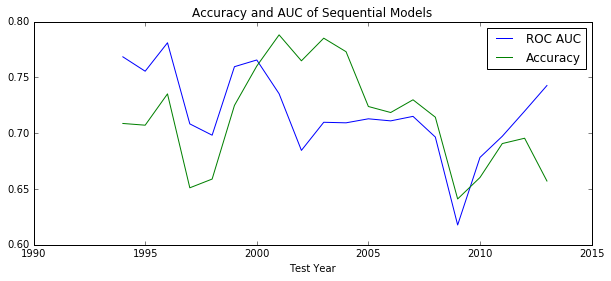

In [171]:
# test with same variables as rf_best
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1, random_state=44))

sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
    start_year=1994, end_year=2013, print_charts=False, print_metrics=True)

### Applying weight decay to samples

One reason could be that there are periodic shifts in sentiment such that older data might be less informative to newer cases. Let's attempt to weight recent samples more than older samples. 

Training model to predict 1994 appeals...
Training Data: (26588, 540) | Test Data: (5009, 540)
0.7
{'Recall': 0.49975669099756692, 'Log Loss': 0.60763114416407682, 'Precision': 0.68926174496644299, 'ROC AUC': 0.75884231369235, 'Accuracy': 0.70233579556797765}
Training model to predict 1995 appeals...
Training Data: (31597, 540) | Test Data: (8196, 540)
0.7
{'Recall': 0.562962962962963, 'Log Loss': 0.57209106723214398, 'Precision': 0.56233814280429151, 'ROC AUC': 0.7629117809585424, 'Accuracy': 0.7116886285993167}
Training model to predict 1996 appeals...
Training Data: (39793, 540) | Test Data: (9952, 540)
0.7
{'Recall': 0.50079829696647149, 'Log Loss': 0.6762849970287208, 'Precision': 0.71804654711942006, 'ROC AUC': 0.7797686751741586, 'Accuracy': 0.73723874598070738}
Training model to predict 1997 appeals...
Training Data: (49745, 540) | Test Data: (7887, 540)
0.7
{'Recall': 0.53431798436142486, 'Log Loss': 0.65527779767000527, 'Precision': 0.62352145995268671, 'ROC AUC': 0.713669978

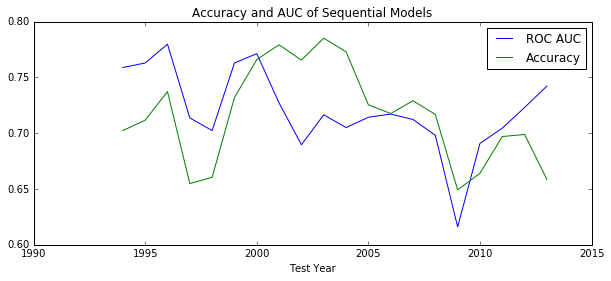

In [172]:
# rf_best + weight decay 0.7 (AUC & Accuracy both up slightly by 0.002)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1, random_state=44))

sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
    start_year=1994, end_year=2013, weight_decay=0.7, print_charts=False, print_metrics=True)

In [284]:
# tune weight decay 

def tune_weight_decay(df, label, cat_features, num_features, impute_methods, start_year, end_year, weight_decay_alphas):
    results = [] 
    for alpha in weight_decay_alphas: 
        result = {} 
        metrics_summary, _, _ = fit_sequential_models(
            df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
            start_year=start_year, end_year=end_year, weight_decay=alpha, print_metrics=False, print_charts=False)
        result['alpha'] = alpha 
        result['average_accuracy'] = metrics_summary['Accuracy'].mean() 
        result['average_roc_auc'] = metrics_summary['ROC AUC'].mean() 
        results.append(result)
    return pd.DataFrame(results)

Training model to predict 1991 appeals...
Training Data: (16524, 656) | Test Data: (3256, 656)
Training model to predict 1992 appeals...
Training Data: (19780, 656) | Test Data: (3724, 656)
Training model to predict 1993 appeals...
Training Data: (23504, 656) | Test Data: (3980, 656)
Training model to predict 1994 appeals...
Training Data: (27484, 656) | Test Data: (5121, 656)
Training model to predict 1995 appeals...
Training Data: (32605, 656) | Test Data: (8394, 656)
Training model to predict 1996 appeals...
Training Data: (40999, 656) | Test Data: (10143, 656)
Training model to predict 1997 appeals...
Training Data: (51142, 656) | Test Data: (8046, 656)
Training model to predict 1998 appeals...
Training Data: (59188, 656) | Test Data: (7887, 656)
Training model to predict 1999 appeals...
Training Data: (67075, 656) | Test Data: (9710, 656)
Training model to predict 2000 appeals...
Training Data: (76785, 656) | Test Data: (9099, 656)
Training model to predict 2001 appeals...
Trainin

,alpha,average_accuracy,average_roc_auc
0,0.1,0.716516,0.713132
1,0.2,0.715975,0.714598
2,0.3,0.718284,0.716445
3,0.4,0.716415,0.715710
4,0.5,0.717911,0.713838
5,0.6,0.716050,0.714006
6,0.7,0.718345,0.720087
7,0.8,0.715720,0.715574
8,0.9,0.716460,0.718978
9,1.0,0.716438,0.715094


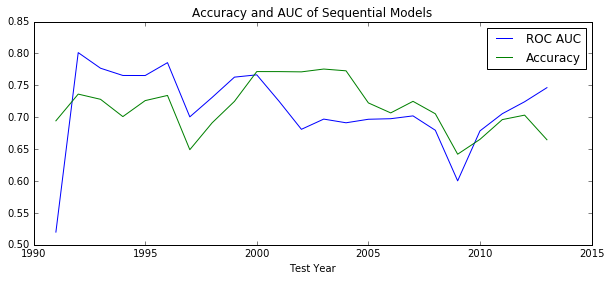

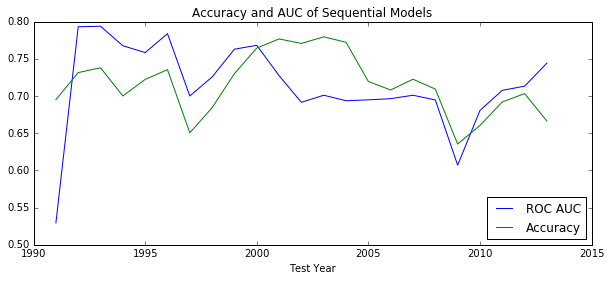

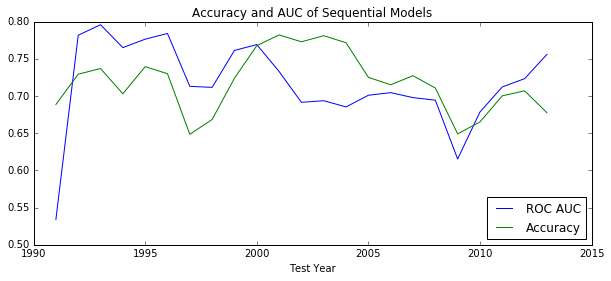

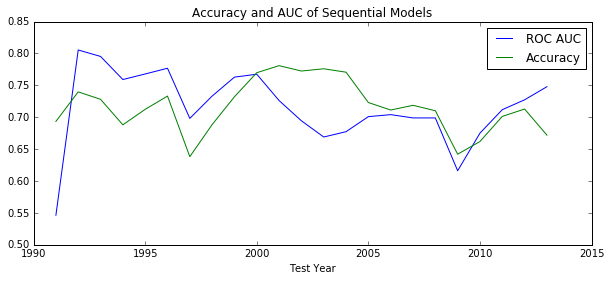

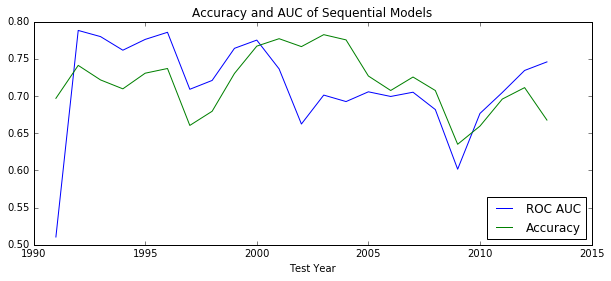

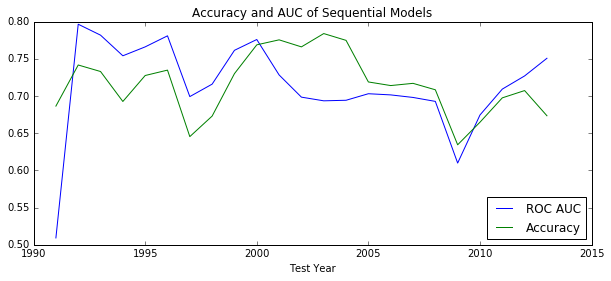

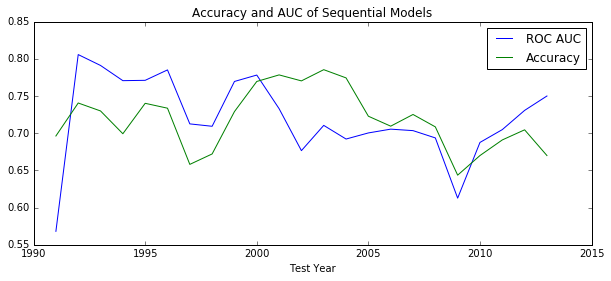

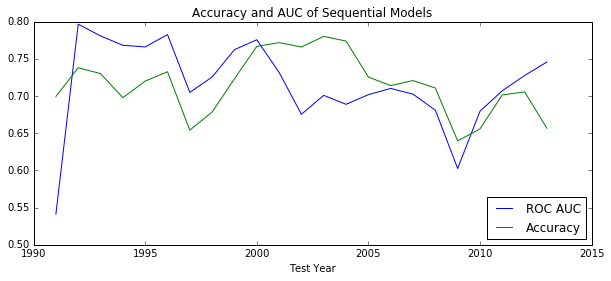

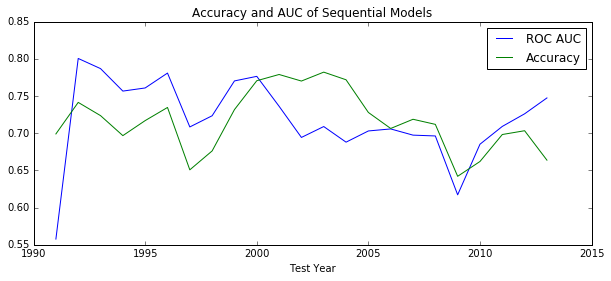

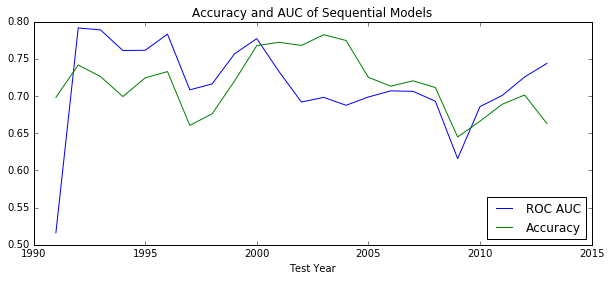

In [285]:
# find best alpha
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1, random_state=44))

weight_decay_tuning = tune_weight_decay(df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, 
                                        impute_methods=IMPUTE_METHODS, start_year=1994, end_year=2013, 
                                        weight_decay_alphas=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
weight_decay_tuning